In [0]:
from google.colab import files
uploaded = files.upload()

Saving HumanActivityRecognition.zip to HumanActivityRecognition.zip


In [29]:
#https://www.geeksforgeeks.org/working-zip-files-python/


# importing required modules 
from zipfile import ZipFile 
  
# specifying the zip file name 
file_name = "HumanActivityRecognition.zip"
  
# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 
    # printing all the contents of the zip file 
    zip.printdir() 
  
    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall('HAR') 
    print('Done!') 


File Name                                             Modified             Size
HAR/                                           2018-09-12 10:20:42            0
HAR/.DS_Store                                  2018-09-12 10:20:36        10244
__MACOSX/                                      2018-09-12 10:20:48            0
__MACOSX/HAR/                                  2018-09-12 10:20:48            0
__MACOSX/HAR/._.DS_Store                       2018-09-12 10:20:36          120
HAR/.ipynb_checkpoints/                        2018-09-12 09:57:28            0
HAR/.ipynb_checkpoints/HAR_EDA-checkpoint.ipynb 2018-09-12 10:20:40      1282064
HAR/.ipynb_checkpoints/HAR_LSTM-checkpoint.ipynb 2018-09-12 10:20:42        16982
HAR/.ipynb_checkpoints/HAR_LSTM_1-checkpoint.ipynb 2018-09-12 09:59:28        15915
HAR/.ipynb_checkpoints/HAR_PREDICTION_MODELS-checkpoint.ipynb 2018-09-12 10:20:40       309214
HAR/HAR_EDA.ipynb                              2018-09-12 10:20:40      1282064
__MACOSX/HAR/._HAR

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 50
batch_size = 16
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

# **Architecture - 1**

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
history = model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

scores = model.evaluate(X_test, Y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))



plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])
plt.show()


Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 128s 17ms/step - loss: 0.3844 - acc: 0.8551 - val_loss: 0.6033 - val_acc: 0.8470
Epoch 2/50
7352/7352 [==============================] - 129s 17ms/step - loss: 0.3880 - acc: 0.8769 - val_loss: 0.6466 - val_acc: 0.8317
Epoch 3/50
7352/7352 [==============================] - 128s 17ms/step - loss: 0.2985 - acc: 0.9121 - val_loss: 0.6130 - val_acc: 0.8534
Epoch 4/50
7352/7352 [==============================] - 128s 17ms/step - loss: 0.3234 - acc: 0.9108 - val_loss: 0.4678 - val_acc: 0.8660
Epoch 5/50
7352/7352 [==============================] - 128s 17ms/step - loss: 0.2683 - acc: 0.9212 - val_loss: 0.5772 - val_acc: 0.8565
Epoch 6/50
7352/7352 [==============================] - 129s 18ms/step - loss: 0.2685 - acc: 0.9204 - val_loss: 0.6047 - val_acc: 0.8629
Epoch 7/50
7352/7352 [==============================] - 128s 17ms/step - loss: 0.2672 - acc: 0.9221 - val_loss: 0.4081 - val_acc: 

NameError: ignored

In [0]:
import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [50, 50]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

Accuracy: 91.35%
Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 536        0         0        0                   0   
SITTING                  1      408        80        0                   0   
STANDING                 0       93       436        1                   0   
WALKING                  0        0         0      445                  28   
WALKING_DOWNSTAIRS       0        0         0        0                 415   
WALKING_UPSTAIRS         0        0         0       12                   7   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             1  
SITTING                            2  
STANDING                           2  
WALKING                           23  
WALKING_DOWNSTAIRS                 5  
WALKING_UPSTAIRS                 452  


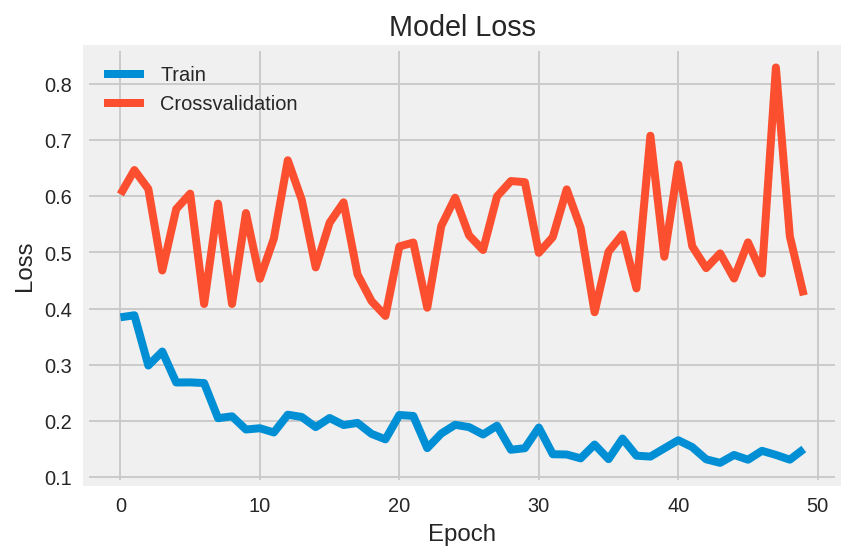

In [0]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

scores = model.evaluate(X_test, Y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))



plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])


# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

# **Architecture - 2**

In [0]:
# Initiliazing the sequential model
model_1 = Sequential()
# Configuring the parameters
model_1.add(LSTM(64, return_sequences = True, input_shape=(timesteps, input_dim)))
model_1.add(Dropout(0.5))
model_1.add(LSTM(64))
model_1.add(Dropout(0.5))
# Adding a dropout layer)
# Adding a dense output layer with sigmoid activation
model_1.add(Dense(n_classes, activation='softmax'))
model_1.summary()
# Compiling the model
history_1 = model_1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________


Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 260s 35ms/step - loss: 0.9313 - acc: 0.6126 - val_loss: 0.7766 - val_acc: 0.7021
Epoch 2/50
7352/7352 [==============================] - 257s 35ms/step - loss: 0.4953 - acc: 0.8300 - val_loss: 0.6223 - val_acc: 0.7886
Epoch 3/50
7352/7352 [==============================] - 255s 35ms/step - loss: 0.2474 - acc: 0.9187 - val_loss: 0.6390 - val_acc: 0.8042
Epoch 4/50
7352/7352 [==============================] - 255s 35ms/step - loss: 0.1958 - acc: 0.9304 - val_loss: 0.4504 - val_acc: 0.8802
Epoch 5/50
7352/7352 [==============================] - 256s 35ms/step - loss: 0.1660 - acc: 0.9391 - val_loss: 0.3642 - val_acc: 0.8809
Epoch 6/50
7352/7352 [==============================] - 256s 35ms/step - loss: 0.1513 - acc: 0.9455 - val_loss: 0.4333 - val_acc: 0.9087
Epoch 7/50
7352/7352 [==============================] - 254s 35ms/step - loss: 0.1411 - acc: 0.9445 - val_loss: 0.3003 - val_acc: 

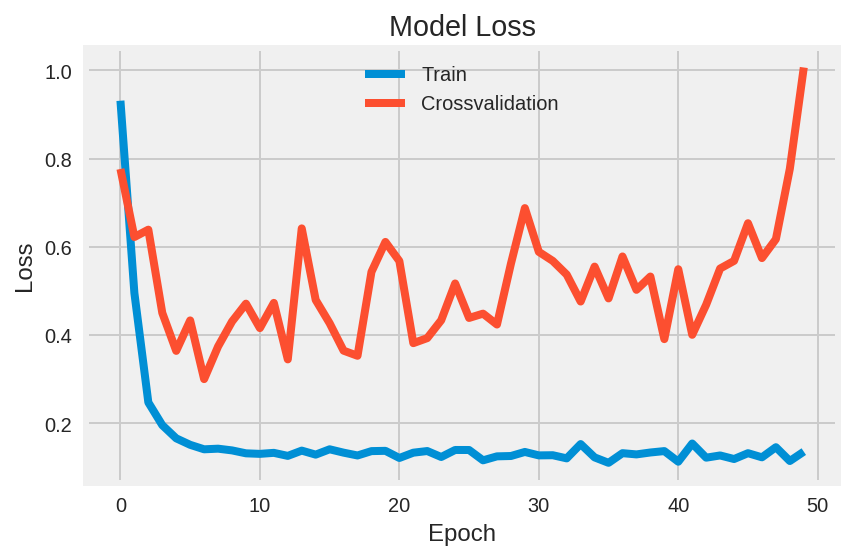

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 509        1        27        0                   0   
SITTING                  0      288       199        0                   0   
STANDING                 0       29       500        1                   2   
WALKING                  0        1         0      462                   8   
WALKING_DOWNSTAIRS       0        0         0        8                 326   
WALKING_UPSTAIRS         0        0         1       15                  11   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            4  
STANDING                           0  
WALKING                           25  
WALKING_DOWNSTAIRS                86  
WALKING_UPSTAIRS                 444  


In [0]:
# Training the model
model_1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

scores = model_1.evaluate(X_test, Y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))



plt.plot(model_1.history.history['loss'])
plt.plot(model_1.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])
plt.show()

# Confusion Matrix
print(confusion_matrix(Y_test, model_1.predict(X_test)))


# **Architecture - 3**

In [0]:
from keras.layers.normalization import BatchNormalization


# Initiliazing the sequential model
model_2 = Sequential()
# Configuring the parameters
model_2.add(LSTM(2, return_sequences = True, input_shape=(timesteps, input_dim)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(LSTM(2))
model.add(BatchNormalization())
model_2.add(Dropout(0.5))
# Adding a dropout layer)
# Adding a dense output layer with sigmoid activation
model_2.add(Dense(n_classes, activation='softmax'))
model_2.summary()
# Compiling the model
history_2 = model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 128, 2)            96        
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 2)            8         
_________________________________________________________________
dropout_15 (Dropout)         (None, 128, 2)            0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dropout_16 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 18        
Total params: 162
Trainable params: 158
Non-trainable params: 4
_________________________________________________________________


Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 257s 35ms/step - loss: 1.6924 - acc: 0.2784 - val_loss: 1.5095 - val_acc: 0.3543
Epoch 2/50
7352/7352 [==============================] - 262s 36ms/step - loss: 1.5084 - acc: 0.3316 - val_loss: 1.4059 - val_acc: 0.3638
Epoch 3/50
7352/7352 [==============================] - 261s 36ms/step - loss: 1.4565 - acc: 0.3384 - val_loss: 1.3488 - val_acc: 0.4143
Epoch 4/50
7352/7352 [==============================] - 259s 35ms/step - loss: 1.4218 - acc: 0.3686 - val_loss: 1.2547 - val_acc: 0.5097
Epoch 5/50
7352/7352 [==============================] - 257s 35ms/step - loss: 1.3711 - acc: 0.3965 - val_loss: 1.1525 - val_acc: 0.5830
Epoch 6/50
7352/7352 [==============================] - 256s 35ms/step - loss: 1.3360 - acc: 0.3959 - val_loss: 1.0949 - val_acc: 0.5606
Epoch 7/50
7352/7352 [==============================] - 256s 35ms/step - loss: 1.3086 - acc: 0.4026 - val_loss: 1.0720 - val_acc: 

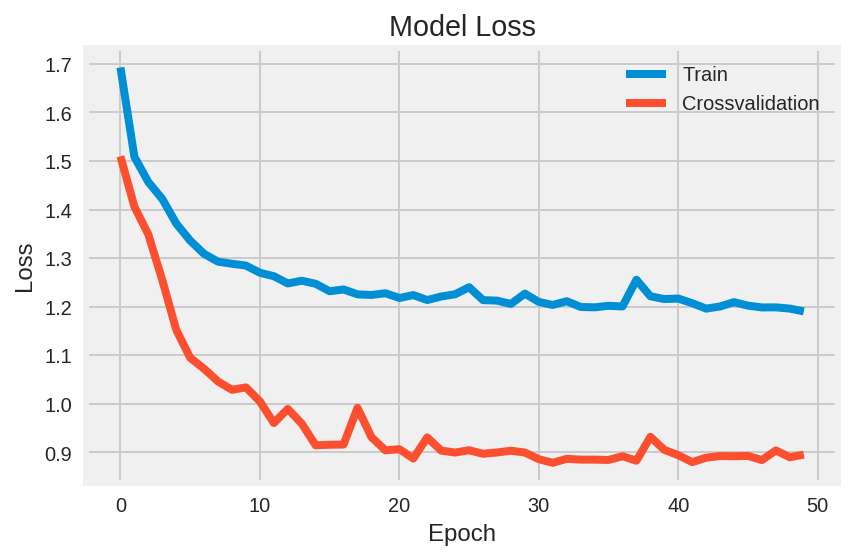

Pred                LAYING  SITTING  STANDING  WALKING
True                                                  
LAYING                 510        0         0       27
SITTING                  0      416        75        0
STANDING                 0      117       415        0
WALKING                  0        0         2      494
WALKING_DOWNSTAIRS       0        0         0      420
WALKING_UPSTAIRS         0        8         5      458


In [0]:
# Training the model
model_2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

scores = model_2.evaluate(X_test, Y_test, verbose = 0)
print("Accuracy: %.2f%%" % (scores[1]*100))



plt.plot(model_2.history.history['loss'])
plt.plot(model_2.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Crossvalidation'])
plt.show()

# Confusion Matrix
print(confusion_matrix(Y_test, model_2.predict(X_test)))


In [33]:
from prettytable import PrettyTable


x = PrettyTable()

x.field_names = ["S.R",'Architectures',"Training Loss","Test loss","Accuracy"]

x.add_row([(1),"Architecture-1","0.1498", 0.4325, '91.35%'])
x.add_row([(2),"Architecture-2","0.1359", 1.0066, '85.82%'])
x.add_row([(3),'Architecture-3',"1.0903", 0.8955, '62.27%'])
print(x.get_string(title = "-----SUMMARY-----"))

+-----+----------------+---------------+-----------+----------+
| S.R | Architectures  | Training Loss | Test loss | Accuracy |
+-----+----------------+---------------+-----------+----------+
|  1  | Architecture-1 |     0.1498    |   0.4325  |  91.35%  |
|  2  | Architecture-2 |     0.1359    |   1.0066  |  85.82%  |
|  3  | Architecture-3 |     1.0903    |   0.8955  |  62.27%  |
+-----+----------------+---------------+-----------+----------+
